# Exploratory data analysis & Simple Classifiers
## Date created: 1 March 2021
### Quick exploration of datasets considered for thesis research.
### Currently contains analyses of: Blog Authorship Corpus

In [1]:
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from langdetect import detect, detect_langs # for language detection


In [2]:
# TODO: write specification scheme for type of "simple" classifier to build and test?
# Maybe just have the notebook build, train, and test all simple ones, i.e., Logit+ n-grams, Logit + grams + linguistic features, etc.
# Specifiy trian-test splits
# What else? --> Label to predict (e.g., age cat, age number, gender, astrological sign, topic)
SEED = 420
MAX_N_GRAM = 2
TEST_SPLIT = 0.2

In [3]:
# Set seed for reproducibility 
np.random.seed(SEED)

In [4]:
# Get pathname of dataset
for dirname, _, filenames in os.walk("../data/blogs_kaggle"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/blogs_kaggle/.DS_Store
../data/blogs_kaggle/blogtext.csv


In [5]:
# Read and load dataset
data = pd.read_csv("../data/blogs_kaggle/blogtext.csv")

In [6]:
# Quick sample/overview of dataframe structure
data.head(15)
# TODO: Remove non-English texts --> See row 2 --> See DialoGPT paper for tips on filtering out languages

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


In [7]:
# Check for missing values/NAs in all variables
data.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [8]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [9]:
# TODO: comment out this cell when running analyses on full dataset.
# Take subset of data for faster testing
data = data.head(100000)

In [10]:
# Shape (i.e., number of datapoints and variables, respectively) of dataframe
data.shape

(100000, 7)

## Exploratory analysis

In [11]:
data.describe(include = ['object', 'bool'])

,gender,topic,sign,date,text
count,100000,100000,100000,100000,100000
unique,2,40,12,1564,97566
top,male,indUnk,Aries,"05,August,2004",urlLink
freq,53358,33097,10637,3087,209


In [12]:
# Convert all columns (except ID and date) to object type
data['age'] = data['age'].astype(object)

Text(0.5, 1.0, 'Unconditional Age Distribution')

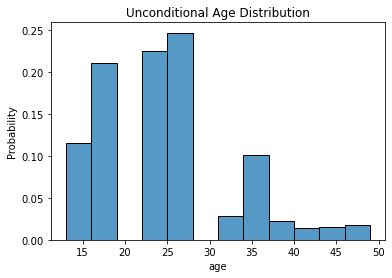

In [13]:
# Age distribution, unconditional
sns.histplot(data, x = "age", binwidth = 3, stat = "probability")
plt.title("Unconditional Age Distribution")

Text(0.5, 1.0, 'Age Distribution, Conditioned On Gender')

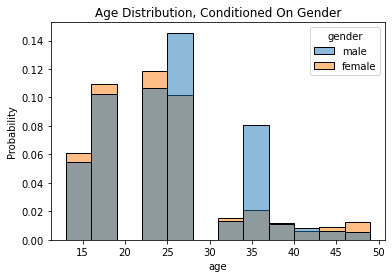

In [14]:
# Age distribution, conditioned on gender
sns.histplot(data, x = "age", hue = "gender", binwidth = 3, stat = "probability")
plt.title("Age Distribution, Conditioned On Gender")

Text(0.5, 1.0, 'Distribution of Astrological Signs')

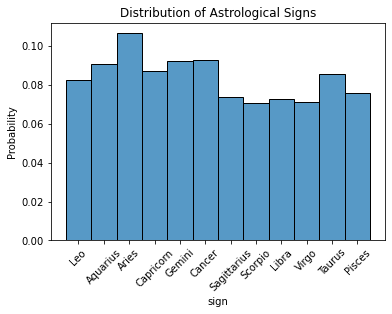

In [15]:
sns.histplot(data, x = 'sign', stat = 'probability')
plt.xticks(rotation=45)
plt.title("Distribution of Astrological Signs")

Text(0.5, 1.0, 'Distribution of Topics')

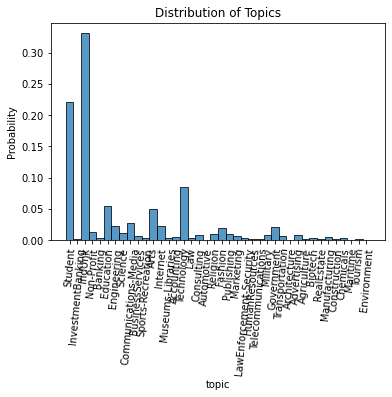

In [16]:
sns.histplot(data, x = 'topic', stat = 'probability')
plt.xticks(rotation=85)
plt.title("Distribution of Topics")

# Examples for Human(e) AI plenary meeting

In [36]:
data_1317 = data[data['age'] < 18]
data_1317.reset_index(drop = True, inplace = True)
data_1317.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3539003,female,14,indUnk,Aries,"07,June,2004",O= optimist P= pessimist My...


In [37]:
data_1317.shape

(32730, 7)

In [53]:
data_1317.text[666]

"       Yahoo! My dad is home! From Dallas! Where he has to work! And soon we'll move down there...! Good and bad, but he has a job there, so that's mostly good. Right? of course right. So he came back today after the final performance of vbs (yay, yay...) and taking my great grandmother some food...that's better than the goo they try to give her. But, now for the meaning of the title...Since i am going into highschool and all that fun stuff, i'll be going a few places by myself and doing things for long periods of time away from parental supervision. So, naturally, i need a way to check in with my folks. (who says folks?) And so, my dad got me a cell phone. Yahoo! I can call anyone in my family for free! So if you want to talk to me, you can call me so you will pay for the time, and i won't! But i can't talk long because i have a limited amount of minutes. And if you want to talk more than a bit (for what reason i don't know) call after 9 pm cause then i get unlimited minutes...but th

In [54]:
data_3347 = data[data['age'] > 32]
data_3347.reset_index(drop = True, inplace = True)
data_3347.shape

(19973, 7)

In [64]:
data_3347.text[2000]

"           BTW, the toxoplasma stuff comes out in the news every few years with the intention of shocking pet owners.  'Oh, it's not my fault for being a slut...my cat has infected me with promiscuous disease.'  If rats are infected, it causes slight behavioural changes, thought to increase the chance of transmission.  Well, it causes no behavioural changes in infected cats.  In humans also, there has been no conclusive evidence to show that behaviour is directly affected by the parasite.  They 'evaluate' people's personalities, and then test if they have the disease.  Well, that ends up being a correlational study.  How do you know that people who like cats don't have certain behavioural characteristics already?  Or that people who are more likely to clean litter boxes don't have a certain personality?  Or maybe people who don't clean their houses are more likely to get it since they would be the most likely candidates for rat infestation.  There is no ethical way to show if there is

## Data cleaning / preprocessing

In [ ]:
# Removing all unwanted text/characters from data['text'] column

# Remove all non-alphabetical characters
data['clean_data'] = data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ', x))

In [ ]:
# Make all letters lower case
data['clean_data'] = data['clean_data'].apply(lambda x: x.lower())

In [ ]:
# Remove white space from beginning and end of string
data['clean_data'] = data['clean_data'].apply(lambda x: x.strip())

In [ ]:
# Remove instances empty strings
before_rm_empty = len(data)
data.drop(data[data.clean_data == ''].index, inplace = True)

print(f'{before_rm_empty - len(data)} instances removed.')

In [ ]:
# Remove texts that are probably not English by filtering blogs that dont contain at least one of the top 50 most used English words

# create dict with most common English words
top_en_words = {}
with open('../data/wordlists/top1000english.txt') as f:
    count = 1
    for line in f:
        key = line.split()[0].lower()
        top_en_words[key] = count
        count += 1
        
        # Stop at top 50 words. Idea taken from DialoGPT paper.
        if count > 50:
            break


data['top_50_en'] = data['clean_data'].apply(lambda x : True if not set(x.split()).isdisjoint(top_en_words) else False)

def top_lang_detect(text):
    
    detected_langs = detect_langs(text)
    
    return detected_langs[0].lang
        

def top_prob_detect(text):
    
    detected_langs = detect_langs(text)
    
    return detected_langs[0].prob

data['top_lang'] = data['clean_data'].apply(top_lang_detect)
data['top_prob'] = data['clean_data'].apply(top_prob_detect)

In [ ]:
data

In [ ]:
# Remove rows without one of top50 most common english words
before_top50_removal = len(data)
data.drop(data[data['top_50_en'] == False].index, inplace = True)
print(f"{before_top50_removal - len(data)} instances dropped")

In [ ]:
before_top_lang = len(data)
data.drop(data[data['top_lang'] != 'en'].index, inplace = True)
print(f'{before_top_lang - len(data)} instances dropped.')

In [ ]:
before_top_prob = len(data)
data.drop(data[data['top_prob'] < 0.9].index, inplace = True)
print(f'{before_top_prob - len(data)} instances dropped.')

In [ ]:
# Remove stop words
stopwords = set(nltk.corpus.stopwords.words('english')) # use set (hash table) data structure for faster lookup
data['clean_data'] = data['clean_data'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

In [ ]:
# Check difference: before
print(f"Unprocessed data =====> {data['text'][0]}")
print(81 * "=")
# After
print(f"Cleaned data so far =====> {data['clean_data'][0]}")

In [ ]:
data['clean_data'][6]

In [ ]:
# Drop columns that are uninformative for writing style (i.e., ID and date)
data.drop(['id', 'date'], axis = 1, inplace = True)

In [ ]:
# Add labels for age categories
def age_to_cat(age):
    '''Returns age category label for given age number.'''
    
    if 13 <= int(age) <= 17:
        return '13-17'
    elif 23 <= int(age) <= 27:
        return '23-27'
    elif 33 <= int(age) <= 47:
        return '33-47'
    else:
        raise ValueError("Given age not in one of pre-defined age groups.")


data['age_cat'] = data['age'].apply(age_to_cat)

In [ ]:
data.head()

In [ ]:
# Merge all possibly interesting labels into one column
data['labels'] = data.apply(lambda col: [col['gender'], str(col['age']), col['topic'], col['sign']], axis = 1)

# Only keep age as label
# data['labels'] = data.apply(lambda col: [str(col['age'])], axis = 1) # TODO: Why keep age as string?
# data['labels'] = data.apply(lambda col: [col['age']], axis = 1)
data['labels'] = data.apply(lambda col: [col['age_cat']], axis = 1)

In [ ]:
data.head()

In [ ]:
# Reduce dataframe to only contain cleaned blogs and list of labels
data = data[['clean_data', 'labels']]


In [ ]:
data.head()

## Classification

In [ ]:
# Split data into features/ X and labels / Y 
X = data['clean_data']
Y = data['labels']

### Bi-gram and tri-gram models

In [ ]:
# bi-gram model
vectorizer = CountVectorizer(binary = True, ngram_range = (1, MAX_N_GRAM))

# fit model
X = vectorizer.fit_transform(X)

In [ ]:
# check out a sample of the uni- and bigrams
print(vectorizer.get_feature_names()[:10])

In [ ]:
# Get label counts
label_counts = {}

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

In [ ]:
label_counts

In [ ]:
# Binarize the labels for prediction 
binarizer = MultiLabelBinarizer(classes = sorted(label_counts.keys()))

In [ ]:
Y = binarizer.fit_transform(data.labels)

In [ ]:
label_counts.keys()

In [ ]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SPLIT)

In [ ]:
# Fit logistic regression model
model = LogisticRegression(solver = 'lbfgs', multi_class='ovr') #TODO: different solveR?
model = OneVsRestClassifier(model) # TODO: Change this  to multi-class classifier for age cats
model.fit(X_train, Y_train)

In [ ]:
# make predictions on test set
Y_pred = model.predict(X_test)

In [ ]:
Y_pred_inversed = binarizer.inverse_transform(Y_pred)
Y_test_inversed = binarizer.inverse_transform(Y_test)

In [ ]:
# Evaluate performance
def print_evaluation_scores(labels, preds):
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    print(f"F1 score: {f1_score(labels, preds, average = 'micro')}")
    print(f"Average precision: {average_precision_score(labels, preds, average = 'micro')}")
    print(f"Average recall: {recall_score(labels, preds, average = 'micro')}")

In [ ]:
print_evaluation_scores(Y_test, Y_pred)